In [0]:
#Check if your runtime is GPU accelerated or not
from tensorflow.python.client import device_lib
hw = device_lib.list_local_devices()
#print(hw)
if "GPU" in str(hw):
  print("Your runtime is GPU accelerated")
else:
  print("Change runtime to GPU accelerated")
!ls
!ls datalab/
!ls datalab/train_cleaned/ | wc -l
# !cp datalab/test1/* datalab/test/
# !cp datalab/train1/* datalab/train/
# !cp datalab/train_cleaned1/* datalab/train_cleaned/
# !mkdir test_median
# !mv *.png test_median
# !rm test_median/background.png test_median/foreground_mask.png

# !mkdir datalab/test1
# !mkdir datalab/train1
# !mkdir datalab/train_cleaned1
# !mv datalab/test/49.png datalab/test/61.png datalab/test/70.png datalab/test/64.png datalab/test/58.png datalab/test/67.png datalab/test/28.png datalab/test/16.png datalab/test/13.png datalab/test/10.png datalab/test/34.png datalab/test/22.png datalab/test/37.png datalab/test/25.png datalab/test/31.png datalab/test/19.png datalab/test/4.png datalab/test/43.png datalab/test/55.png datalab/test/7.png datalab/test/40.png datalab/test/1.png datalab/test/46.png datalab/test/52.png -t datalab/test1
# !mv datalab/train_cleaned/63.png datalab/train_cleaned/62.png datalab/train_cleaned/60.png datalab/train_cleaned/48.png datalab/train_cleaned/59.png datalab/train_cleaned/65.png datalab/train_cleaned/71.png datalab/train_cleaned/8.png datalab/train_cleaned/72.png datalab/train_cleaned/66.png datalab/train_cleaned/9.png datalab/train_cleaned/14.png datalab/train_cleaned/29.png datalab/train_cleaned/15.png datalab/train_cleaned/17.png datalab/train_cleaned/12.png datalab/train_cleaned/39.png datalab/train_cleaned/11.png datalab/train_cleaned/38.png datalab/train_cleaned/35.png datalab/train_cleaned/21.png datalab/train_cleaned/20.png datalab/train_cleaned/36.png datalab/train_cleaned/23.png datalab/train_cleaned/27.png datalab/train_cleaned/33.png datalab/train_cleaned/32.png datalab/train_cleaned/26.png datalab/train_cleaned/18.png datalab/train_cleaned/30.png datalab/train_cleaned/24.png datalab/train_cleaned/56.png datalab/train_cleaned/42.png datalab/train_cleaned/5.png datalab/train_cleaned/57.png datalab/train_cleaned/41.png datalab/train_cleaned/69.png datalab/train_cleaned/68.png datalab/train_cleaned/54.png datalab/train_cleaned/6.png datalab/train_cleaned/44.png datalab/train_cleaned/2.png datalab/train_cleaned/50.png datalab/train_cleaned/3.png datalab/train_cleaned/51.png datalab/train_cleaned/45.png datalab/train_cleaned/53.png datalab/train_cleaned/47.png -t datalab/train_cleaned1
# !mv datalab/train/63.png datalab/train/62.png datalab/train/60.png datalab/train/48.png datalab/train/59.png datalab/train/65.png datalab/train/71.png datalab/train/8.png datalab/train/72.png datalab/train/66.png datalab/train/9.png datalab/train/14.png datalab/train/29.png datalab/train/15.png datalab/train/17.png datalab/train/12.png datalab/train/39.png datalab/train/11.png datalab/train/38.png datalab/train/35.png datalab/train/21.png datalab/train/20.png datalab/train/36.png datalab/train/23.png datalab/train/27.png datalab/train/33.png datalab/train/32.png datalab/train/26.png datalab/train/18.png datalab/train/30.png datalab/train/24.png datalab/train/56.png datalab/train/42.png datalab/train/5.png datalab/train/57.png datalab/train/41.png datalab/train/69.png datalab/train/68.png datalab/train/54.png datalab/train/6.png datalab/train/44.png datalab/train/2.png datalab/train/50.png datalab/train/3.png datalab/train/51.png datalab/train/45.png datalab/train/53.png datalab/train/47.png datalab/train1

Your runtime is GPU accelerated
datalab  submission.csv  tb  test_median  train_median
adc.json  test	test1  train  train1  train_cleaned  train_cleaned1
144


In [0]:
'''
Prj#5: scikit/numpy solution using single layer convolution(3x3 kernel, same padding) => random forrest
No external dependencies except dataset.
'''
# !pip install joblib
import concurrent.futures
import csv
import logging
import random

import joblib
import numpy as np
import sklearn.ensemble
import sklearn.cross_validation
import sklearn.metrics

import skimage.data

from pathlib import Path

from PIL import Image as image

TRAIN_DIR = Path("./datalab/train/")
TARGET_DIR = Path("./datalab/train_cleaned/")
TEST_DIR = Path("./datalab/test/")

CHUNKSIZE = 2000000

logging.basicConfig(level=logging.INFO)

def get_padded(imgarray, padding=1):
    padval = int(round(imgarray.flatten().mean()))
    rows, cols = imgarray.shape
    xpad = np.full((rows, padding), padval, dtype='uint8')
    ypad = np.full((padding, cols + 2 * padding), padval, dtype='uint8')
    return np.vstack((ypad, np.hstack((xpad, imgarray, xpad)), ypad))

def get_features_for_image(imgarray, padding=1):
    rows, cols = imgarray.shape
    padded = get_padded(imgarray, padding=padding)
    features = []
    return np.vstack(tuple(
        np.vstack(tuple(
            padded[i: i + 2 * padding + 1, j: j + 2 * padding + 1].reshape((1, -1))
            for j in range(cols)
        )) for i in range(rows)
    ))

def get_features_for_path(path, padding=1):
    return get_features_for_image(skimage.data.imread(str(path)), padding=padding)

def get_target_for_path(path):
    return skimage.data.imread(str(path)).flatten() / 255

def get_training_sets():
    X = list(joblib.Parallel(n_jobs=-1)(
        joblib.delayed(get_features_for_path)(i)
        for i in TRAIN_DIR.iterdir()))
    y = list(joblib.Parallel(n_jobs=-1)(
        joblib.delayed(get_target_for_path)(i)
        for i in TARGET_DIR.iterdir()))
    X = np.concatenate(X)
    y = np.concatenate(y)
    logging.info("Finished loading")
    return X, y

def get_model(X, y):
    model = sklearn.ensemble.RandomForestRegressor(
        n_estimators=0, warm_start=True, n_jobs=-1)
    indices = list(range(0, X.shape[0], CHUNKSIZE))
    indices.append(X.shape[0])
    for i in range(len(indices) - 1):
        if not (i + 1) % 10:
            logging.info("Fitting {} of {}".format(i + 1, len(indices) - 1))
        start, end = indices[i], indices[i + 1]
        model.set_params(n_estimators=model.get_params()["n_estimators"] + 1)
        model.fit(X[start: end], y[start: end])
    logging.info("Finished Training")
    return model

def get_index_and_features(path):
    imgarray = skimage.data.imread(str(path))
    X = get_features_for_image(imgarray)
    index = []
    for i in range(imgarray.shape[0]):
        for j in range(imgarray.shape[1]):
            index.append("{}_{}_{}".format(path.stem, i + 1, j + 1))
    return index, X

def get_test_set():
    index = []
    X = []
    for imgindex, imgfeatures in joblib.Parallel(n_jobs=-1)(
            joblib.delayed(get_index_and_features)(i)
            for i in TEST_DIR.iterdir()):
        index.extend(imgindex)
        X.append(imgfeatures)
    logging.info("Finished Loading Test Set")
    X = np.vstack(X)
    assert(len(index) == X.shape[0])
    return index, X


def write_submission(model, index, X, path):
    with path.open('w', encoding='utf-8', newline='') as outf:
        writer = csv.writer(outf)
        writer.writerow(('id', 'value'))
        writer.writerows(zip(index, model.predict(X)))
    

def main():
    trainX, trainy = get_training_sets()
    model = get_model(trainX, trainy)
    index, testX = get_test_set()
    write_submission(model, index, testX, Path("submission.csv"))
    
if __name__ == "__main__":
    main()

INFO:root:Finished loading
INFO:root:Fitting 10 of 15
INFO:root:Finished Training
INFO:root:Finished Loading Test Set


In [0]:
def check_number_of_pixels_imgdir(in_path):
  '''
  Number of Predictions (mandated by competition):
  We expect the solution file to have 14230080 prediction rows. This file should have a header row. Please see sample submission file on the data page.
  Below function calculates total entries arrived at using formula = (#images*img.shape[0]*img.shape[1])
  '''
  
  import os
  
  t=0
  for f in os.listdir(in_path):    
    img = np.asarray(Image.open(out_path))
    t += img.shape[0]*img.shape[1]
  return t

tick=time.time()
print(check_number_of_pixels_imgdir('test_op/'))
tock=time.time()
print('time taken: '+str(tock-tick))

16329600
time taken: 0.46344494819641113
total 7368
-rw-r--r-- 1 root root 151594 Jun 20 13:32 100.png
-rw-r--r-- 1 root root 160977 Jun 20 13:32 103.png
-rw-r--r-- 1 root root 153190 Jun 20 13:32 106.png
-rw-r--r-- 1 root root 155287 Jun 20 13:32 109.png
-rw-r--r-- 1 root root 146144 Jun 20 13:32 112.png
-rw-r--r-- 1 root root 156257 Jun 20 13:32 115.png
-rw-r--r-- 1 root root 148217 Jun 20 13:32 118.png
-rw-r--r-- 1 root root 157995 Jun 20 13:32 121.png
-rw-r--r-- 1 root root 148457 Jun 20 13:32 124.png
-rw-r--r-- 1 root root 159234 Jun 20 13:32 127.png
-rw-r--r-- 1 root root 150525 Jun 20 13:32 130.png
-rw-r--r-- 1 root root 154069 Jun 20 13:32 133.png
-rw-r--r-- 1 root root 144109 Jun 20 13:32 136.png
-rw-r--r-- 1 root root 155563 Jun 20 13:32 139.png
-rw-r--r-- 1 root root 146713 Jun 20 13:32 142.png
-rw-r--r-- 1 root root 162468 Jun 20 13:32 145.png
-rw-r--r-- 1 root root 155978 Jun 20 13:32 148.png
-rw-r--r-- 1 root root 163517 Jun 20 13:32 151.png
-rw-r--r-- 1 root root 157709 

In [0]:
def download_dataset_to_collab(dataset):
  '''
  Google Drive is a tag-based (also called semantic) file system, which, for example, allows a file to be in several places at the same time 
  (just by adding IDs of folders to the file's parents property)
  Hence to get the file/folder ID, navigate to the folder using browser & note the ID from URL 
  Ex: https://drive.google.com/drive/folders/1mZVxppM8dHFcoKdc9Vu9vS-n_GGnpCkO
  '''
  #Code to download files from google drive to collab using Pydrive

  !pip install -U -q PyDrive

  from pydrive.auth import GoogleAuth
  from pydrive.drive import GoogleDrive
  from google.colab import auth
  from oauth2client.client import GoogleCredentials
  import time

  # 1. Authenticate and create the PyDrive client.
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)

  # Auto-iterate through all files in the folder ID.
  start = time.time()
  for key, value in dataset.items():
    print("Initiating files copy from {} ...".format(key))
    file_list = drive.ListFile({'q': "'{}' in parents and trashed=false".format(value)}).GetList()      #file_list = drive.ListFile({'q': "'1czmCOb4w0LiWetvQyhIxi6gGvJuAYb5F' in parents and trashed=false"}).GetList()
    for file1 in file_list:      
      file6 = drive.CreateFile({'id': file1['id']}) # Initialize GoogleDriveFile instance with file id.
      file6.GetContentFile(file1['title'])          # Download file as file1['title']
    !mkdir 'datalab/'$key                           # move the data to folder in dictionary
    !ls -l datalab/
    !mv *.png 'datalab/'$key
    !ls -l datalab/
    print("Completed files copy from {}.".format(key))

  end = time.time()                                                                
  return 'time taken:'+ str(end-start) +'seconds'

dataset = {
          #'<folder_name>':'<gdrive_folder_id>'
          'train':'1mZVxppM8dHFcoKdc9Vu9vS-n_GGnpCkO', 
          'test':'1czmCOb4w0LiWetvQyhIxi6gGvJuAYb5F',
          'train_cleaned':'1T4uCpfZueGsSUCu145FuEcPY_he6A2fQ'
          }
download_dataset_to_collab(dataset)

Initiating files copy from train ...
total 8
-rw-r--r-- 1 root root 2171 Jun 21 06:40 adc.json
drwxr-xr-x 2 root root 4096 Jun 21 06:42 train
total 8
-rw-r--r-- 1 root root 2171 Jun 21 06:40 adc.json
drwxr-xr-x 2 root root 4096 Jun 21 06:42 train
Completed files copy from train.
Initiating files copy from test ...
total 12
-rw-r--r-- 1 root root 2171 Jun 21 06:40 adc.json
drwxr-xr-x 2 root root 4096 Jun 21 06:43 test
drwxr-xr-x 2 root root 4096 Jun 21 06:42 train
total 12
-rw-r--r-- 1 root root 2171 Jun 21 06:40 adc.json
drwxr-xr-x 2 root root 4096 Jun 21 06:43 test
drwxr-xr-x 2 root root 4096 Jun 21 06:42 train
Completed files copy from test.
Initiating files copy from train_cleaned ...
total 16
-rw-r--r-- 1 root root 2171 Jun 21 06:40 adc.json
drwxr-xr-x 2 root root 4096 Jun 21 06:43 test
drwxr-xr-x 2 root root 4096 Jun 21 06:42 train
drwxr-xr-x 2 root root 4096 Jun 21 06:44 train_cleaned
total 16
-rw-r--r-- 1 root root 2171 Jun 21 06:40 adc.json
drwxr-xr-x 2 root root 4096 Jun 21 06

'time taken:250.7804605960846seconds'

In [0]:
import numpy as np
from scipy import signal
from PIL import Image
from matplotlib import pyplot as plt
import os

class median_filter_and_thresholding():
  """
  Simple background removal code

  __author__ : Rangel Dokov

  The basic idea is that we have a foreground object of interest (the dark text)
  and we want to remove everything that is not part of this foreground object.

  This should produce results somewhere around 0.06 on the leaderboard.
  """

  def load_image(self, path):
    return np.asarray(Image.open(path))/255.0

  def save(self, path, img):
    tmp = np.asarray(img*255.0, dtype=np.uint8)
    Image.fromarray(tmp).save(path)

  def denoise_image(self, inp):
    # estimate 'background' color by a median filter
    bg = signal.medfilt2d(inp, 11)
    self.save('background.png', bg)

    # thresholding: compute 'foreground' mask as anything that is significantly darker than the background
    mask = inp < bg - 0.1
    self.save('foreground_mask.png', mask)

    # return the input value for all pixels in the mask or pure white otherwise
    return np.where(mask, inp, 1.0)

m = median_filter_and_thresholding()  
imgdir_path='/content/datalab/test/'
for f in os.listdir(imgdir_path):
  inp_path=imgdir_path+str(f)
  inp = m.load_image(inp_path)
  out = m.denoise_image(inp)
  out_path = f
  m.save(out_path, out)  


In [0]:
def img2csv(imgdir_path,csv_name):
  '''
  This function flattens input image(s) from provided path to array=>(pixel_id,pixel_intensity_value)
  '''
  import time
  import os
  import numpy as np
  from PIL import Image as Image
  import csv
  img_no=1
  tick=time.time()
  for f in os.listdir(imgdir_path):
    out_path=imgdir_path+str(f)
    img = np.asarray(Image.open(out_path))/255.0
    print('writing img#{} to csv'.format(img_no))
    for index in np.ndindex(img.shape[:]):    
      with open(csv_name, 'a') as csvfile:
          writer = csv.writer(csvfile, delimiter=',',quotechar='|', quoting=csv.QUOTE_MINIMAL)
          writer.writerow( [ str(f.split('.')[0])+'_'+str(index[0]+1)+'_'+str(index[1]+1) ]+[ str(img[index[0],index[1]]) ] )
    img_no+=1
    tock1=time.time()
    print('time to copy {}: {}'.format(f,str(tock1-tick)))
  tock=time.time()
  return 'time taken: '+str(tock-tick)

img2csv('datalab/train_cleaned/','train_cleaned.csv')

writing img#1 to csv
time to copy 183.png: 15.499060869216919
writing img#2 to csv
time to copy 56.png: 25.07726764678955
writing img#3 to csv
time to copy 92.png: 40.592365741729736
writing img#4 to csv
time to copy 32.png: 50.14067459106445
writing img#5 to csv
time to copy 50.png: 59.66117262840271
writing img#6 to csv
time to copy 182.png: 75.17591857910156
writing img#7 to csv
time to copy 110.png: 90.73227524757385
writing img#8 to csv
time to copy 105.png: 106.2534568309784
writing img#9 to csv
time to copy 138.png: 121.93554043769836
writing img#10 to csv
time to copy 99.png: 137.37348461151123
writing img#11 to csv
time to copy 62.png: 146.93444657325745
writing img#12 to csv
time to copy 59.png: 156.50678420066833
writing img#13 to csv
time to copy 108.png: 172.0984537601471
writing img#14 to csv
time to copy 12.png: 181.69309449195862
writing img#15 to csv
time to copy 119.png: 197.18895030021667
writing img#16 to csv
time to copy 155.png: 212.7899832725525
writing img#17 to

time to copy 65.png: 771.9516253471375
writing img#58 to csv
time to copy 213.png: 787.4093194007874
writing img#59 to csv
time to copy 83.png: 802.792445898056
writing img#60 to csv
time to copy 98.png: 818.5159742832184
writing img#61 to csv
time to copy 126.png: 833.9696080684662
writing img#62 to csv
time to copy 24.png: 843.4770398139954
writing img#63 to csv
time to copy 72.png: 852.9030067920685
writing img#64 to csv
time to copy 180.png: 868.3621077537537
writing img#65 to csv
time to copy 174.png: 883.8732032775879
writing img#66 to csv
time to copy 141.png: 899.2639937400818
writing img#67 to csv
time to copy 189.png: 914.6497993469238
writing img#68 to csv
time to copy 30.png: 924.1340477466583
writing img#69 to csv
time to copy 122.png: 939.6108891963959
writing img#70 to csv
time to copy 135.png: 954.9622447490692
writing img#71 to csv
time to copy 194.png: 970.2685871124268
writing img#72 to csv
time to copy 125.png: 985.6736679077148
writing img#73 to csv
time to copy 86

time to copy 216.png: 1522.0567195415497
writing img#114 to csv
time to copy 131.png: 1537.373825788498
writing img#115 to csv
time to copy 111.png: 1552.70428109169
writing img#116 to csv
time to copy 101.png: 1567.9181008338928
writing img#117 to csv
time to copy 74.png: 1583.119149684906
writing img#118 to csv
time to copy 96.png: 1598.2864394187927
writing img#119 to csv
time to copy 18.png: 1607.6615068912506
writing img#120 to csv
time to copy 75.png: 1622.9005699157715
writing img#121 to csv
time to copy 21.png: 1632.2765843868256
writing img#122 to csv
time to copy 200.png: 1647.5256667137146
writing img#123 to csv
time to copy 104.png: 1662.8447947502136
writing img#124 to csv
time to copy 150.png: 1678.1939792633057
writing img#125 to csv
time to copy 192.png: 1693.5271770954132
writing img#126 to csv
time to copy 132.png: 1708.8015356063843
writing img#127 to csv
time to copy 195.png: 1724.1345500946045
writing img#128 to csv
time to copy 38.png: 1733.5716261863708
writing i

'time taken: 1937.8511793613434'

In [0]:
#@title Functions to download files from collab to local system/gdrive

def save_file_to_local(filename):
  '''
  files.download is useful for downloading small files from collab book to local drive. 
  Note: for bigger file size > 100MB, try storing file to google drive & download thereafter.
  '''
  
  from google.colab import files

  files.download(filename)
  
def save_file_to_gdrive(name, path):
  '''
  Upload the file to Drive. See:
  https://developers.google.com/drive/v3/reference/files/create
  https://developers.google.com/drive/v3/web/manage-uploads
  '''
  
  from googleapiclient.http import MediaFileUpload
  from googleapiclient.discovery import build
  
  drive_service = build('drive', 'v3')
  file_metadata = {
  'name': name,
  'mimeType': 'application/octet-stream'
  }
  media = MediaFileUpload(path, mimetype='application/octet-stream',resumable=True)
  created = drive_service.files().create(body=file_metadata, media_body=media,fields='id').execute()
  print('File ID: {}'.format(created.get('id')))
  return created

save_file_to_gdrive('train_cleaned.csv','/content/train_cleaned.csv')

adc.json
183_1_1,1.0
183_1_2,1.0
183_1_3,1.0
183_1_4,1.0
183_1_5,1.0
****
183_1_1,0.8901960784313725
183_1_2,0.8823529411764706
183_1_3,0.8980392156862745
183_1_4,0.8823529411764706
183_1_5,0.8705882352941177


In [0]:
!ls

def csv2np1(input_csv):
  import numpy as np
  return np.genfromtxt(input_csv,delimiter=',')

import time
def csv2np(input_csv):
  '''
  using csv module to read data & np.asarray method to covert to numpy array is 10X faster than using np.genfromtxt()
  '''
  import csv
  import numpy as np
  with open(input_csv,'r') as dest_f:
      data_iter = csv.reader(dest_f, delimiter = ',', quotechar = '"')
      data = [data for data in data_iter]
  np_array = np.asarray(data, dtype = float)    
  return np_array

tick=time.time()
#y_train = csv2np('/content/train_cleaned.csv')
y_train1 = csv2np1('/content/train_cleaned.csv')
tock=time.time()
print(tock-tick)
#X_train = csv2np('/content/train.csv')
X_train1 = csv2np1('/content/train.csv')
tock=time.time()
print(tock-tick)

datalab  train_cleaned.csv  train.csv
125.94951009750366
258.1544303894043


In [0]:
import numpy as np
def linear_reg_keras(X_train, y_train, y_test, epoch=10, bsize=16):
  from keras.models import Sequential
  from keras.layers.core import Dense, Activation
  model = Sequential()
#   model.add(Dense(2,1,init='uniform', activation='linear'))
  model.add(Dense(32, input_dim=(28460160,)))
  model.add(Activation('linear'))
  model.summary()

  model.compile(loss='mse', optimizer='rmsprop')

  model.fit(X_train, y_train, epochs=epoch, batch_size=bsize, verbose=1)
  score = model.evaluate(X_test, y_test, bsize=16)

def lin_reg1(x,y):
  from keras.layers import Input, Dense
  from keras.models import Model

  inputs = Input(shape=(1,))
  preds = Dense(1,activation='linear')(inputs)

  model = Model(inputs=inputs,outputs=preds)
  model.summary()
  #sgd=keras.optimizers.SGD()
  model.compile(optimizer='rmsprop' ,loss='mse',metrics=['mse'])
  model.fit(x,y, batch_size=32, epochs=3, shuffle=True)

x=np.transpose(X_train1[:,1])
y=np.transpose(y_train1[:,1])
print(y.shape)
print(x.shape)
print(type(x))

#linear_reg_keras(x, y, x, epoch=1)
lin_reg1(x,y)

(28460160,)
(28460160,)
<class 'numpy.ndarray'>
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3
   51744/28460160 [..............................] - ETA: 1:22:31 - loss: 0.0112 - mean_squared_error: 0.0112

  422912/28460160 [..............................] - ETA: 1:02:32 - loss: 0.0091 - mean_squared_error: 0.0091

  792640/28460160 [..............................] - ETA: 1:00:35 - loss: 0.0090 - mean_squared_error: 0.0090

 1169408/28460160 [>.............................] - ETA: 59:13 - loss: 0.0089 - mean_squared_error: 0.0089

 1551520/28460160 [>.............................] - ETA: 58:01 - loss: 0.0089 - mean_squared_error: 0.0089

 1930304/28460160 [=>............................] - ETA: 57:04 - loss: 0.0089 - mean_squared_error: 0.0089

 2316224/28460160 [=>............................] - ETA: 55:58 - loss: 0.0089 - mean_squared_error: 0.0089

 2697216/28460160 [=>............................] - ETA: 55:04 - loss: 0.0089 - mean_squared_error: 0.0089

 3082880/28460160 [==>...........................] - ETA: 54:06 - loss: 0.0089 - mean_squared_error: 0.0089

 3464000/28460160 [==>...........................] - ETA: 53:14 - loss: 0.0089 - mean_squared_error: 0.0089

 3845760/28460160 [===>..........................] - ETA: 52:23 - loss: 0.0088 - mean_squared_error: 0.0088

 4223744/28460160 [===>..........................] - ETA: 51:35 - loss: 0.0089 - mean_squared_error: 0.0089

 4600096/28460160 [===>..........................] - ETA: 50:49 - loss: 0.0088 - mean_squared_error: 0.0088

 4981696/28460160 [====>.........................] - ETA: 49:58 - loss: 0.0088 - mean_squared_error: 0.0088

 5358112/28460160 [====>.........................] - ETA: 49:12 - loss: 0.0088 - mean_squared_error: 0.0088

 5733952/28460160 [=====>........................] - ETA: 48:26 - loss: 0.0088 - mean_squared_error: 0.0088

 6111488/28460160 [=====>........................] - ETA: 47:39 - loss: 0.0088 - mean_squared_error: 0.0088

 6489952/28460160 [=====>........................] - ETA: 46:50 - loss: 0.0088 - mean_squared_error: 0.0088

 6864512/28460160 [======>.......................] - ETA: 46:04 - loss: 0.0088 - mean_squared_error: 0.0088

 7240608/28460160 [======>.......................] - ETA: 45:17 - loss: 0.0088 - mean_squared_error: 0.0088

 7616448/28460160 [=======>......................] - ETA: 44:29 - loss: 0.0088 - mean_squared_error: 0.0088

 7994048/28460160 [=======>......................] - ETA: 43:41 - loss: 0.0088 - mean_squared_error: 0.0088

 8361728/28460160 [=======>......................] - ETA: 42:58 - loss: 0.0088 - mean_squared_error: 0.0088

 8731776/28460160 [========>.....................] - ETA: 42:12 - loss: 0.0088 - mean_squared_error: 0.0088

 9106496/28460160 [========>.....................] - ETA: 41:25 - loss: 0.0088 - mean_squared_error: 0.0088

 9482368/28460160 [========>.....................] - ETA: 40:37 - loss: 0.0088 - mean_squared_error: 0.0088

 9856608/28460160 [=========>....................] - ETA: 39:50 - loss: 0.0088 - mean_squared_error: 0.0088

10233440/28460160 [=========>....................] - ETA: 39:01 - loss: 0.0088 - mean_squared_error: 0.0088

10611264/28460160 [==========>...................] - ETA: 38:13 - loss: 0.0088 - mean_squared_error: 0.0088

10988000/28460160 [==========>...................] - ETA: 37:24 - loss: 0.0088 - mean_squared_error: 0.0088

11363008/28460160 [==========>...................] - ETA: 36:37 - loss: 0.0088 - mean_squared_error: 0.0088

11738144/28460160 [===========>..................] - ETA: 35:49 - loss: 0.0088 - mean_squared_error: 0.0088

12111200/28460160 [===========>..................] - ETA: 35:01 - loss: 0.0088 - mean_squared_error: 0.0088

12488192/28460160 [============>.................] - ETA: 34:13 - loss: 0.0088 - mean_squared_error: 0.0088

12863488/28460160 [============>.................] - ETA: 33:25 - loss: 0.0088 - mean_squared_error: 0.0088

13241792/28460160 [============>.................] - ETA: 32:36 - loss: 0.0088 - mean_squared_error: 0.0088

13619040/28460160 [=============>................] - ETA: 31:48 - loss: 0.0088 - mean_squared_error: 0.0088

13995232/28460160 [=============>................] - ETA: 30:59 - loss: 0.0088 - mean_squared_error: 0.0088

14371680/28460160 [==============>...............] - ETA: 30:11 - loss: 0.0088 - mean_squared_error: 0.0088

14748064/28460160 [==============>...............] - ETA: 29:23 - loss: 0.0088 - mean_squared_error: 0.0088

15121216/28460160 [==============>...............] - ETA: 28:35 - loss: 0.0088 - mean_squared_error: 0.0088

15496320/28460160 [===============>..............] - ETA: 27:47 - loss: 0.0088 - mean_squared_error: 0.0088

15872384/28460160 [===============>..............] - ETA: 26:59 - loss: 0.0088 - mean_squared_error: 0.0088

16247808/28460160 [================>.............] - ETA: 26:11 - loss: 0.0088 - mean_squared_error: 0.0088

16623680/28460160 [================>.............] - ETA: 25:22 - loss: 0.0088 - mean_squared_error: 0.0088

16998560/28460160 [================>.............] - ETA: 24:34 - loss: 0.0088 - mean_squared_error: 0.0088

17372064/28460160 [=================>............] - ETA: 23:46 - loss: 0.0088 - mean_squared_error: 0.0088

17745824/28460160 [=================>............] - ETA: 22:59 - loss: 0.0088 - mean_squared_error: 0.0088

18118912/28460160 [==================>...........] - ETA: 22:11 - loss: 0.0088 - mean_squared_error: 0.0088

18490208/28460160 [==================>...........] - ETA: 21:23 - loss: 0.0088 - mean_squared_error: 0.0088

18860864/28460160 [==================>...........] - ETA: 20:36 - loss: 0.0088 - mean_squared_error: 0.0088

19237408/28460160 [===================>..........] - ETA: 19:47 - loss: 0.0088 - mean_squared_error: 0.0088

19614240/28460160 [===================>..........] - ETA: 18:59 - loss: 0.0088 - mean_squared_error: 0.0088

19990976/28460160 [====================>.........] - ETA: 18:10 - loss: 0.0088 - mean_squared_error: 0.0088

20364992/28460160 [====================>.........] - ETA: 17:22 - loss: 0.0088 - mean_squared_error: 0.0088

20738752/28460160 [====================>.........] - ETA: 16:34 - loss: 0.0088 - mean_squared_error: 0.0088

21113728/28460160 [=====================>........] - ETA: 15:46 - loss: 0.0088 - mean_squared_error: 0.0088

21488608/28460160 [=====================>........] - ETA: 14:58 - loss: 0.0088 - mean_squared_error: 0.0088

21813920/28460160 [=====================>........] - ETA: 14:16 - loss: 0.0088 - mean_squared_error: 0.0088

In [0]:
#JUNK

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Input, Conv2D
from keras.layers import Activation, Dropout, Flatten, Dense, MaxPooling2D, UpSampling2D, AveragePooling2D
from keras.layers.advanced_activations import LeakyReLU, PReLU, ThresholdedReLU
from keras import backend as K
from keras.callbacks import TensorBoard


# dimensions of our images.
img_width, img_height = 540, 420

X_train_data_dir = 'datalab/train'
y_train_data_dir = 'datalab/train_cleaned'
nb_train_samples = 144
epochs = 10
batch_size = 16

# this is the augmentation configuration we will use for training
X_train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    #shear_range=0.2,
    #zoom_range=0.2,
    #horizontal_flip=True
    )

# this is the augmentation configuration we will use for testing:
# only rescaling
y_train_datagen = ImageDataGenerator(rescale=1. / 255)

X_train_generator = X_train_datagen.flow_from_directory(
    X_train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='input')

y_train_generator = y_train_datagen.flow_from_directory(
    y_train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='input')

# from PIL import Image
# im = Image.open("./datalab/test/52.png")
# print(im.format, im.size, im.mode)
# im.split()
# plt.grid(False)
# plt.imshow(np.asarray(im))

# im1 = Image.open("./test_op/91.png")
# print(im1.format, im.size, im.mode)
# im1.split()
# plt.imshow(np.asarray(im1))

!ls test_op

Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.
ls: cannot access 'test_op': No such file or directory


In [0]:
input_img = Input(shape=(420, 540, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(32, (3, 3), activation='relu', use_bias=True, padding='same')(input_img)
x = Dropout(0.1)(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', use_bias=True, padding='same')(x)
x = Dropout(0.1)(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (7, 7, 32)

x = Conv2D(32, (3, 3), activation='relu', use_bias=True, padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', use_bias=True, padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='rmsprop', loss='mse')
autoencoder.summary()
autoencoder.fit(X_train, y_train,
            epochs=30,
            batch_size=4,
            shuffle=True,
            #validation_data=(X_train, y_train),
            callbacks=[TensorBoard(log_dir='/content/tb', histogram_freq=0, write_graph=False)]
            )

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        (None, 420, 540, 1)       0         
_________________________________________________________________
conv2d_67 (Conv2D)           (None, 420, 540, 32)      320       
_________________________________________________________________
dropout_7 (Dropout)          (None, 420, 540, 32)      0         
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 210, 270, 32)      0         
_________________________________________________________________
conv2d_68 (Conv2D)           (None, 210, 270, 32)      9248      
_________________________________________________________________
dropout_8 (Dropout)          (None, 210, 270, 32)      0         
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 105, 135, 32)      0         
__________

96/96 [==============================] - 3s 32ms/step - loss: 0.0524
Epoch 3/30
96/96 [==============================] - 3s 32ms/step - loss: 0.0410
Epoch 4/30
96/96 [==============================] - 3s 32ms/step - loss: 0.0333
Epoch 5/30
96/96 [==============================] - 3s 32ms/step - loss: 0.0310
Epoch 6/30
96/96 [==============================] - 3s 32ms/step - loss: 0.0289
Epoch 7/30
96/96 [==============================] - 3s 32ms/step - loss: 0.0257
Epoch 8/30
96/96 [==============================] - 3s 32ms/step - loss: 0.0241
Epoch 9/30
96/96 [==============================] - 3s 32ms/step - loss: 0.0218
Epoch 10/30
96/96 [==============================] - 3s 32ms/step - loss: 0.0212
Epoch 11/30
72/96 [=====================>........] - ETA: 0s - loss: 0.0204

96/96 [==============================] - 3s 32ms/step - loss: 0.0199
Epoch 12/30
96/96 [==============================] - 3s 32ms/step - loss: 0.0191
Epoch 13/30
96/96 [==============================] - 3s 32ms/step - loss: 0.0181
Epoch 14/30
96/96 [==============================] - 3s 32ms/step - loss: 0.0172
Epoch 15/30
96/96 [==============================] - 3s 32ms/step - loss: 0.0162
Epoch 16/30
96/96 [==============================] - 3s 32ms/step - loss: 0.0156
Epoch 17/30
96/96 [==============================] - 3s 32ms/step - loss: 0.0154
Epoch 18/30
96/96 [==============================] - 3s 32ms/step - loss: 0.0148
Epoch 19/30
96/96 [==============================] - 3s 32ms/step - loss: 0.0141
Epoch 20/30
68/96 [====================>.........] - ETA: 0s - loss: 0.0139

96/96 [==============================] - 3s 32ms/step - loss: 0.0138
Epoch 21/30
96/96 [==============================] - 3s 32ms/step - loss: 0.0133
Epoch 22/30
96/96 [==============================] - 3s 32ms/step - loss: 0.0130
Epoch 23/30
96/96 [==============================] - 3s 32ms/step - loss: 0.0131
Epoch 24/30
96/96 [==============================] - 3s 32ms/step - loss: 0.0118
Epoch 25/30
96/96 [==============================] - 3s 32ms/step - loss: 0.0121
Epoch 26/30
96/96 [==============================] - 3s 32ms/step - loss: 0.0120
Epoch 27/30
96/96 [==============================] - 3s 32ms/step - loss: 0.0114
Epoch 28/30
96/96 [==============================] - 3s 32ms/step - loss: 0.0111
Epoch 29/30
68/96 [====================>.........] - ETA: 0s - loss: 0.0108

96/96 [==============================] - 3s 32ms/step - loss: 0.0109
Epoch 30/30
96/96 [==============================] - 3s 32ms/step - loss: 0.0109


x_test
(420, 540, 1)


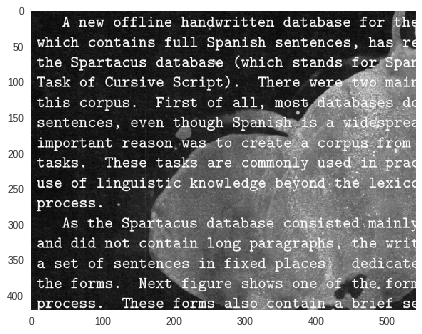

decoded_imgs
(420, 540, 1)


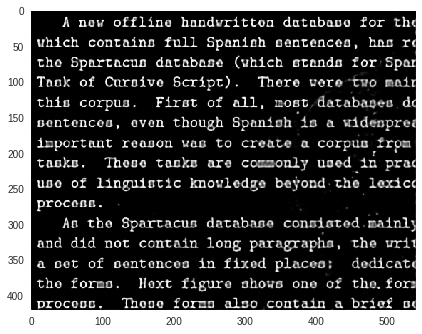

test_median
PNG (540, 420) L


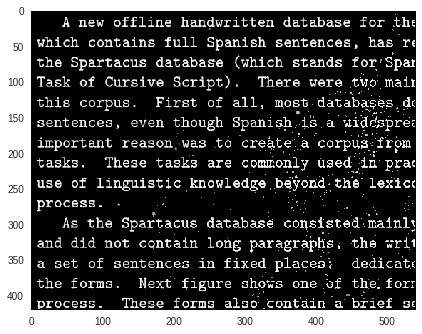

In [0]:
decoded_imgs = autoencoder.predict(x_test)

def show_img_from_np(x_test):
  from matplotlib import pyplot as plt
  first_array=x_test
  #Not sure you even have to do that if you just want to visualize it
  first_array=255.*first_array
  first_array=first_array.astype("float32")
  print(first_array.shape)
  plt.imshow(first_array.reshape(420,540))
  plt.grid(False)
  plt.show()

i=17 
print('x_test')
show_img_from_np(x_test[i])
print('decoded_imgs')
show_img_from_np(decoded_imgs[i])

test_list=(187,157,151,100,178,145,139,208,163,169,199,154,136,106,184,196,118,205,88,193,214,160,79,94,124,211,97,91,172,112,82,142,115,127,109,103,73,121,190,202,85,76,130,175,133,166,148,181)
print('test_median')
im = Image.open('./test_median/'+str(test_list[i])+'.png')
print(im.format, im.size, im.mode)
im.split()
plt.grid(False)
plt.imshow(np.asarray(im))

# print('test')
# im = Image.open("datalab/test/208.png")
# print(im.format, im.size, im.mode)
# im.split()
# plt.grid(False)
# plt.imshow(np.asarray(im))

# n = 2
# plt.figure(figsize=(540, 420))
# for i in range(n):
#     # display original
#     ax = plt.subplot(2, n, i+1)
#     plt.imshow(x_test[i].reshape(540, 420))
#     plt.gray()
#     ax.get_xaxis().set_visible(False)
#     ax.get_yaxis().set_visible(False)

#     # display reconstruction
#     ax = plt.subplot(2, n, i + n)
#     plt.imshow(decoded_imgs[i].reshape(540, 420))
#     plt.gray()
#     ax.get_xaxis().set_visible(False)
#     ax.get_yaxis().set_visible(False)
# plt.show()


In [0]:
def img2nparray(path):
  from scipy import ndimage
  from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
  import os
  import numpy as np

  train_files = []
  y_train = []
  i=0
  #for _file in onlyfiles:
  for _file in os.listdir(path):
      train_files.append(_file)
  #     label_in_file = _file.find("_")
  #     y_train.append(int(_file[0:label_in_file]))

  print("Files in train_files: {}".format(len(train_files)))

  # Original Dimensions
  image_width = 540
  image_height = 420
  # ratio = 4

  # image_width = int(image_width / ratio)
  # image_height = int(image_height / ratio)

  # channels = 3
  channels = 1
  # nb_classes = 1

  dataset = np.ndarray(shape=(len(train_files), image_height, image_width, channels),
                       dtype=np.float32)

  i = 0
  for _file in train_files:
      img = load_img(path + "/" + _file,grayscale=True)  # this is a PIL image
      img.thumbnail((image_width, image_height))
      # Convert to Numpy Array
      x = img_to_array(img)  
  #     x = x.reshape((3, 120, 160))
  #     # Normalize
  #     x = (x - 128.0) / 128.0
      x = x / 256.0
      print(_file)
      dataset[i] = x
      i += 1
      if i % 250 == 0:
          print("%d images to array" % i)
  print("All images to array!")
  return dataset

path='datalab/train'
# path='train_median'
X_train = img2nparray(path)
print(X_train.shape)
print(X_train[1,1,1,0])

path='datalab/train_cleaned'
y_train = img2nparray(path)
print(y_train.shape)
print(y_train[1,1,1,0])

path='datalab/test'
# path='test_median'
x_test = img2nparray(path)
print(x_test.shape)
print(x_test[1,1,1,0])

# t=(139,208,124,148,145,211,103,202,112,76,199,166,79,172,73,178,169,82,181,190,151,205,160,175,157,187,214,85,193,133,100,109,154,115,184,127,130,136,94,142,196,106,97,163,118,121,91,88)
# print(t[24])

Files in train_files: 96
215.png
74.png
173.png
86.png
111.png
101.png
185.png
179.png
126.png
180.png
161.png
90.png
89.png
159.png
96.png
189.png
81.png
188.png
95.png
108.png
174.png
195.png
92.png
162.png
192.png
98.png
144.png
182.png
113.png
78.png
123.png
129.png
165.png
83.png
77.png
171.png
122.png
150.png
99.png
207.png
201.png
183.png
107.png
200.png
198.png
132.png
141.png
170.png
167.png
152.png
114.png
212.png
137.png
158.png
216.png
177.png
146.png
155.png
84.png
209.png
143.png
194.png
149.png
102.png
134.png
117.png
93.png
153.png
128.png
105.png
80.png
135.png
125.png
186.png
110.png
120.png
75.png
213.png
204.png
197.png
116.png
164.png
203.png
147.png
119.png
156.png
206.png
87.png
191.png
138.png
168.png
210.png
176.png
140.png
104.png
131.png
All images to array!
(96, 420, 540, 1)
0.8984375
Files in train_files: 96
215.png
74.png
173.png
86.png
111.png
101.png
185.png
179.png
126.png
180.png
161.png
90.png
89.png
159.png
96.png
189.png
81.png
188.png
95.png
108.pn

In [0]:
file_list=(139,208,124,148,145,211,103,202,112,76,199,166,79,172,73,178,169,82,181,190,151,205,160,175,157,187,214,85,193,133,100,109,154,115,184,127,130,136,94,142,196,106,97,163,118,121,91,88)
print(len(file_list))
# for x in file_list:
#   print(x)
import numpy as np
out=(decoded_imgs.reshape(48,420,540))
print(np.ndindex(out.shape))
print(out[1,1,1])
t=0
for x in range(len(file_list)):
  c = out[x,:,:]
  print(c)
  for index in np.ndindex(c.shape[:]):    
    print(index)
    print([ str(file_list[t])+'_'+str(index[0]+1)+'_'+str(index[1]+1) ]+[ str(out[t,index[0],index[1]]) ])
    t += 1


48
0.99959415
[[0.98633456 0.9981232  0.9985129  ... 0.92079175 0.8283129  0.67424154]
 [0.99600935 0.9994649  0.9995832  ... 0.9732853  0.8951849  0.7526121 ]
 [0.9984452  0.9999006  0.9999372  ... 0.9968123  0.97759354 0.87963957]
 ...
 [0.91150194 0.98989886 0.9955042  ... 0.9865129  0.90657157 0.6848021 ]
 [0.86888677 0.9769807  0.9891495  ... 0.97592247 0.88807225 0.7111431 ]
 [0.7579126  0.9188984  0.9523346  ... 0.9436614  0.86525446 0.71400636]]
(0, 0)
['139_1_1', '0.98633456']
(0, 1)
['208_1_2', '0.9984503']
(0, 2)
['124_1_3', '0.9988451']
(0, 3)
['148_1_4', '0.99865687']
(0, 4)
['145_1_5', '0.99793905']
(0, 5)
['211_1_6', '0.99581486']
(0, 6)
['103_1_7', '0.99598086']
(0, 7)
['202_1_8', '0.9945042']
(0, 8)
['112_1_9', '0.9944916']
(0, 9)
['76_1_10', '0.9945879']
(0, 10)
['199_1_11', '0.99538994']
(0, 11)
['166_1_12', '0.9898537']
(0, 12)
['79_1_13', '0.9955069']
(0, 13)
['172_1_14', '0.9955751']
(0, 14)
['73_1_15', '0.99563545']
(0, 15)
['178_1_16', '0.9921389']
(0, 16)
['169

IndexError: ignored

In [0]:
!ls test_op | wc -l
!ls
# # !rm test_op/*
# !ls test_op | wc -l
# # !mkdir test1_op
# !mv *.png test_op
# import scipy.misc
# file_list=(139,208,124,148,145,211,103,202,112,76,199,166,79,172,73,178,169,82,181,190,151,205,160,175,157,187,214,85,193,133,100,109,154,115,184,127,130,136,94,142,196,106,97,163,118,121,91,88)
# print(len(file_list))
# import numpy as np
# out=(decoded_imgs.reshape(48,420,540))*255
# print(out.shape[0])
# for i in range(out.shape[0]):
#   scipy.misc.toimage(out[i,:,:]).save(str(file_list[i])+'.png')
#   print(out[i,:,:])

72
datalab  eggs.csv  tb  test1_op  test_op
mv: cannot stat '*.png': No such file or directory


In [0]:
import time
import csv
img_no=1
tick=time.time()
for f in os.listdir('test_op/'):
  out_path='test_op/'+str(f)
  img = np.asarray(Image.open(out_path))/255.0
  print('writing img#{} to csv'.format(img_no))
  for index in np.ndindex(img.shape[:]):    
    with open('mix.csv', 'a') as csvfile:
        writer = csv.writer(csvfile, delimiter=',',quotechar='|', quoting=csv.QUOTE_MINIMAL)
        writer.writerow( [ str(f.split('.')[0])+'_'+str(index[0]+1)+'_'+str(index[1]+1) ]+[ str(img[index[0],index[1]]) ] )
  img_no+=1
  tock1=time.time()
  print('time to copy {}: {}'.format(f,str(tock1-tick)))
#   if img_no > 1:
#     break
tock=time.time()
print('time taken: '+str(tock-tick))


writing img#1 to csv
time to copy 139.png: 19.046212434768677
writing img#2 to csv
time to copy 208.png: 37.7044460773468
writing img#3 to csv
time to copy 124.png: 56.12141466140747
writing img#4 to csv
time to copy 52.png: 67.40902614593506
writing img#5 to csv
time to copy 34.png: 78.93252611160278
writing img#6 to csv
time to copy 148.png: 98.6608555316925
writing img#7 to csv
time to copy 7.png: 110.80612754821777
writing img#8 to csv
time to copy 43.png: 123.15857148170471
writing img#9 to csv
time to copy 145.png: 143.55552458763123
writing img#10 to csv
time to copy 19.png: 156.26391124725342
writing img#11 to csv
time to copy 211.png: 176.9255428314209
writing img#12 to csv
time to copy 64.png: 188.86388206481934
writing img#13 to csv
time to copy 103.png: 207.67635464668274
writing img#14 to csv
time to copy 202.png: 226.31746435165405
writing img#15 to csv
time to copy 46.png: 237.6920382976532
writing img#16 to csv
time to copy 112.png: 256.1651451587677
writing img#17 to c

time to copy 127.png: 935.624433517456
writing img#58 to csv
time to copy 130.png: 955.9474806785583
writing img#59 to csv
time to copy 136.png: 975.4132404327393
writing img#60 to csv
time to copy 94.png: 994.7887065410614
writing img#61 to csv
time to copy 142.png: 1013.6540644168854
writing img#62 to csv
time to copy 196.png: 1032.2470948696136
writing img#63 to csv
time to copy 106.png: 1050.978933095932
writing img#64 to csv
time to copy 97.png: 1070.7883684635162
writing img#65 to csv
time to copy 4.png: 1083.2243268489838
writing img#66 to csv
time to copy 61.png: 1095.5931296348572
writing img#67 to csv
time to copy 163.png: 1117.203075170517
writing img#68 to csv
time to copy 28.png: 1130.1534895896912
writing img#69 to csv
time to copy 118.png: 1152.0264854431152
writing img#70 to csv
time to copy 121.png: 1172.6309924125671
writing img#71 to csv
time to copy 91.png: 1191.31014752388
writing img#72 to csv
time to copy 88.png: 1209.7989268302917
time taken: 1209.7996008396149


In [0]:
# Upload the file to Drive. See:
#
# https://developers.google.com/drive/v3/reference/files/create
# https://developers.google.com/drive/v3/web/manage-uploads
from googleapiclient.http import MediaFileUpload
from googleapiclient.discovery import build
def save_file_to_drive(name, path):
  drive_service = build('drive', 'v3')
  file_metadata = {
  'name': name,
  'mimeType': 'application/octet-stream'
  }
  media = MediaFileUpload(path, mimetype='application/octet-stream',resumable=True)
  created = drive_service.files().create(body=file_metadata, media_body=media,fields='id').execute()
  print('File ID: {}'.format(created.get('id')))
  return created
save_file_to_drive('random_forrest.csv','/content/submission.csv')

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.locked_file'

During handling of the above exception, another exceptio

File ID: 1Wg7bO7yE6lyY_iUrlEvL8ThRGhgwtp9W


{'id': '1Wg7bO7yE6lyY_iUrlEvL8ThRGhgwtp9W'}

In [0]:
'''
Understanding vstack & hstack
'''
import numpy as np
a = np.array([[1,2], [3,4]])
print(a.shape)
print(a.flatten().shape)
print(a)
print(a.flatten())
print(type(a.flatten()))
b=np.full((3,4),2.5)
print(b)
print('***********************')
a = np.array([[1,2],[2,4],[3,3]])
print(a.shape)
print(a)
b = np.array([[2,4],[3,7],[4,1]])
print(b.shape)
print(b)
print(np.hstack((a,b)))
print(np.hstack((a,b)).shape)
print(a.reshape((1,-1)).shape)
a.reshape((1,-1))

(2, 2)
(4,)
[[1 2]
 [3 4]]
[1 2 3 4]
<class 'numpy.ndarray'>
[[2.5 2.5 2.5 2.5]
 [2.5 2.5 2.5 2.5]
 [2.5 2.5 2.5 2.5]]
***********************
(3, 2)
[[1 2]
 [2 4]
 [3 3]]
(3, 2)
[[2 4]
 [3 7]
 [4 1]]
[[1 2 2 4]
 [2 4 3 7]
 [3 3 4 1]]
(3, 4)
(1, 6)


array([[1, 2, 2, 4, 3, 3]])